## 1. Setup

In [1]:
import sys
sys.path.append('../')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import skimage

from seg_reg_net import SegRegNet
from utils.preprocessing.misc import gaussian_smoothing

Using TensorFlow backend.


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## 2. SegRegNet

In [4]:
model = SegRegNet(input_shape=(256, 256, 3), loss_weights=[0.3, 0.7])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 32) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 64) 18496       max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

## Load an image with its GT

In [5]:
def desc_img(img, title=''):
    print(title, img.shape, img.dtype, (img.min(), img.max()), img.sum())

In [6]:
MULT_FACTOR = 500.

img_path = '../datasets/toy_set/train/images/001cell.png'
dots_path = '../datasets/toy_set/train/gt_dots/001dots.png'
img = skimage.io.imread(img_path) / 255.
dots = (skimage.io.imread(dots_path) > 0).max(axis=-1).astype(np.uint8)
gt_seg_map = (gaussian_smoothing([dots], sigma=6) > 1e-6)[..., np.newaxis]
gt_density_map = MULT_FACTOR * gaussian_smoothing([dots.astype(np.float64)], sigma=5)[..., np.newaxis]

desc_img(img,  'img:')
desc_img(dots, 'dots:')
desc_img(gt_seg_map, 'seg_map:')
desc_img(gt_density_map, 'reg_map:')

img: (256, 256, 3) float64 (0.0, 0.9882352941176471) 20235.415686274508
dots: (256, 256) uint8 (0, 1) 135
seg_map: (1, 256, 256, 1) bool (False, True) 48681
reg_map: (1, 256, 256, 1) float64 (0.0, 10.006646745205634) 67500.00000000001


## Predict

In [7]:
preds = model.predict(img[np.newaxis])
print(len(preds))

pred1 = preds[0]
pred2 = preds[1]

desc_img(pred1, 'pred1:')
desc_img(pred2, 'pred2:')

2
pred1: (1, 256, 256, 1) float32 (0.4684978, 0.5708411) 34137.215
pred2: (1, 256, 256, 1) float32 (-0.18174803, 0.19673452) 1378.0509


## Plot

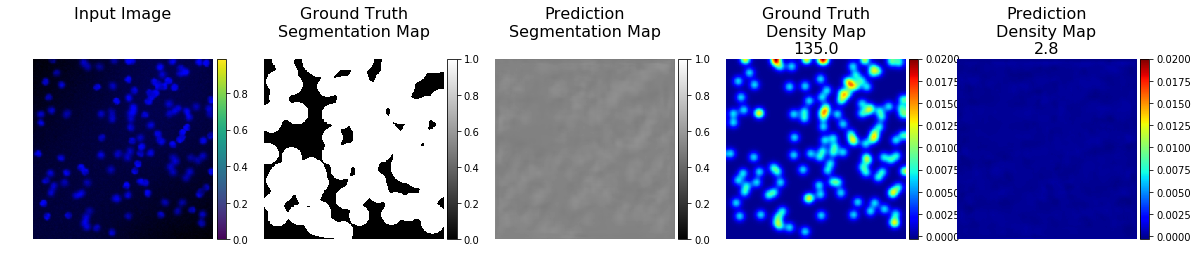

In [8]:
def plot_maps(img, gt_seg_map, pred1, gt_density_map, pred2):
    fraction = 0.047
    pad = 0.02
    fontsize = 16

    num_plots = 5
    plt.figure(figsize=(20, 6))
    plt.subplot(1, num_plots, 1)
    plt.title('Input Image\n\n', fontsize=fontsize)
    plt.imshow(img)
    plt.colorbar(fraction=fraction, pad=pad)
    plt.axis('off')
    
    vmin = min(gt_seg_map.min(), pred1.min())
    vmax = max(gt_seg_map.max(), pred1.max())
    plt.subplot(1, num_plots, 2)
    plt.title('Ground Truth\nSegmentation Map\n', fontsize=fontsize)
    plt.imshow(gt_seg_map.squeeze().astype(np.float32), cmap='gray', vmin=vmin, vmax=vmax)
    plt.colorbar(fraction=fraction, pad=pad)
    plt.axis('off')
    plt.subplot(1, num_plots, 3)
    plt.title('Prediction\nSegmentation Map\n', fontsize=fontsize)
    plt.imshow(pred1.squeeze(), cmap='gray', vmin=vmin, vmax=vmax)
    plt.colorbar(fraction=fraction, pad=pad)
    plt.axis('off')
    
    vmin = min(gt_density_map.min(), pred2.min()) / MULT_FACTOR
    vmax = max(gt_density_map.max(), pred2.max()) / MULT_FACTOR
    plt.subplot(1, num_plots, 4)
    plt.title(f'Ground Truth\nDensity Map\n{gt_density_map.sum()/MULT_FACTOR:.1f}', fontsize=fontsize)
    plt.imshow(gt_density_map.squeeze()/MULT_FACTOR, cmap='jet', vmin=vmin, vmax=vmax)
    plt.colorbar(fraction=fraction, pad=pad)
    plt.axis('off')
    plt.subplot(1, num_plots, 5)
    plt.title(f'Prediction\nDensity Map\n{pred2.sum()/MULT_FACTOR:.1f}', fontsize=fontsize)
    plt.imshow(pred2[0].squeeze()/MULT_FACTOR, cmap='jet', vmin=vmin, vmax=vmax)
    plt.colorbar(fraction=fraction, pad=pad)
    plt.axis('off')
    plt.show()

plot_maps(img, gt_seg_map, pred1, gt_density_map, pred2)

## Train the model on a single example (sanity check)

In [9]:
x = img[np.newaxis]
y = [gt_seg_map, gt_density_map]

Epoch 1/1
 - 2s - loss: 0.6665 - activation_1_loss: 0.6635 - conv2d_12_loss: 0.6678
Epoch 1/1
 - 0s - loss: 0.6175 - activation_1_loss: 0.4709 - conv2d_12_loss: 0.6804
Epoch 1/1
 - 0s - loss: 0.4426 - activation_1_loss: 0.4543 - conv2d_12_loss: 0.4376
Epoch 1/1
 - 0s - loss: 0.4314 - activation_1_loss: 0.4386 - conv2d_12_loss: 0.4284
Epoch 1/1
 - 0s - loss: 0.4048 - activation_1_loss: 0.4190 - conv2d_12_loss: 0.3987
Epoch 1/1
 - 0s - loss: 0.3961 - activation_1_loss: 0.3999 - conv2d_12_loss: 0.3945
Epoch 1/1
 - 0s - loss: 0.3678 - activation_1_loss: 0.3809 - conv2d_12_loss: 0.3622
Epoch 1/1
 - 0s - loss: 0.3596 - activation_1_loss: 0.3774 - conv2d_12_loss: 0.3520
Epoch 1/1
 - 0s - loss: 0.3358 - activation_1_loss: 0.3928 - conv2d_12_loss: 0.3114
Epoch 1/1
 - 0s - loss: 0.2955 - activation_1_loss: 0.3298 - conv2d_12_loss: 0.2808
Epoch 1/1
 - 0s - loss: 0.2791 - activation_1_loss: 0.3678 - conv2d_12_loss: 0.2412
Epoch 1/1
 - 0s - loss: 0.2338 - activation_1_loss: 0.2881 - conv2d_12_loss:

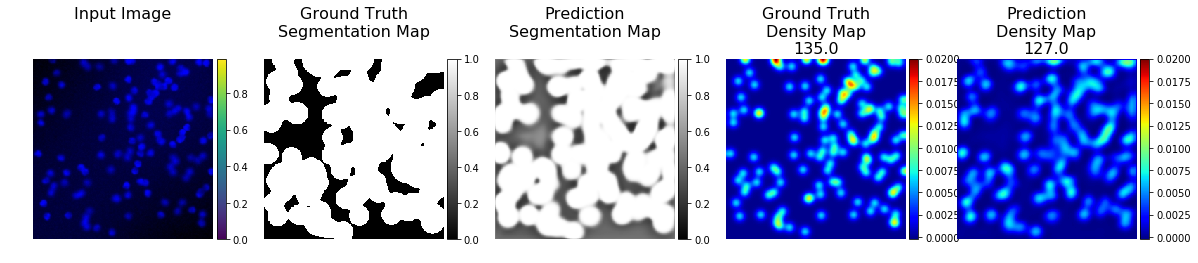

Epoch 1/1
 - 0s - loss: 0.1562 - activation_1_loss: 0.1913 - conv2d_12_loss: 0.1411
Epoch 1/1
 - 0s - loss: 0.1683 - activation_1_loss: 0.1741 - conv2d_12_loss: 0.1658
Epoch 1/1
 - 0s - loss: 0.1468 - activation_1_loss: 0.1745 - conv2d_12_loss: 0.1349
Epoch 1/1
 - 0s - loss: 0.1413 - activation_1_loss: 0.1761 - conv2d_12_loss: 0.1264
Epoch 1/1
 - 0s - loss: 0.1267 - activation_1_loss: 0.1399 - conv2d_12_loss: 0.1211
Epoch 1/1
 - 0s - loss: 0.1317 - activation_1_loss: 0.1795 - conv2d_12_loss: 0.1112
Epoch 1/1
 - 0s - loss: 0.1071 - activation_1_loss: 0.1095 - conv2d_12_loss: 0.1060
Epoch 1/1
 - 0s - loss: 0.1181 - activation_1_loss: 0.1586 - conv2d_12_loss: 0.1007
Epoch 1/1
 - 0s - loss: 0.1102 - activation_1_loss: 0.0982 - conv2d_12_loss: 0.1153
Epoch 1/1
 - 0s - loss: 0.0951 - activation_1_loss: 0.0929 - conv2d_12_loss: 0.0960
Epoch 1/1
 - 0s - loss: 0.1017 - activation_1_loss: 0.0799 - conv2d_12_loss: 0.1111
Epoch 1/1
 - 0s - loss: 0.0876 - activation_1_loss: 0.0772 - conv2d_12_loss:

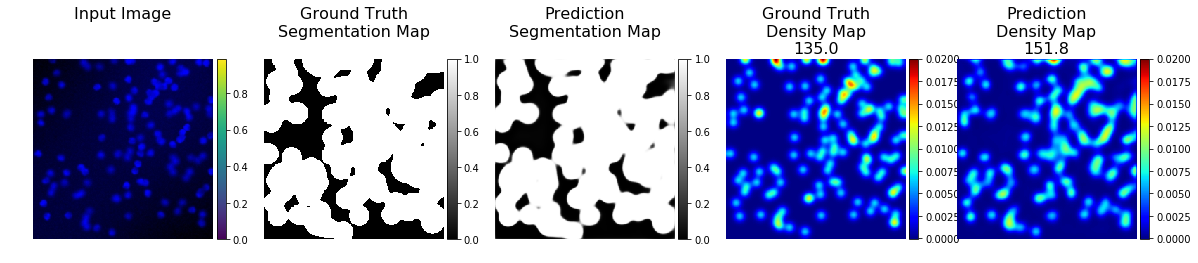

Epoch 1/1
 - 0s - loss: 0.0671 - activation_1_loss: 0.0484 - conv2d_12_loss: 0.0751
Epoch 1/1
 - 0s - loss: 0.0696 - activation_1_loss: 0.0919 - conv2d_12_loss: 0.0600
Epoch 1/1
 - 0s - loss: 0.0584 - activation_1_loss: 0.0647 - conv2d_12_loss: 0.0557
Epoch 1/1
 - 0s - loss: 0.0562 - activation_1_loss: 0.0606 - conv2d_12_loss: 0.0544
Epoch 1/1
 - 0s - loss: 0.0550 - activation_1_loss: 0.0535 - conv2d_12_loss: 0.0557
Epoch 1/1
 - 0s - loss: 0.0581 - activation_1_loss: 0.0415 - conv2d_12_loss: 0.0652
Epoch 1/1
 - 0s - loss: 0.0469 - activation_1_loss: 0.0406 - conv2d_12_loss: 0.0496
Epoch 1/1
 - 0s - loss: 0.0494 - activation_1_loss: 0.0431 - conv2d_12_loss: 0.0520
Epoch 1/1
 - 0s - loss: 0.0477 - activation_1_loss: 0.0475 - conv2d_12_loss: 0.0478
Epoch 1/1
 - 0s - loss: 0.0461 - activation_1_loss: 0.0498 - conv2d_12_loss: 0.0445
Epoch 1/1
 - 0s - loss: 0.0420 - activation_1_loss: 0.0383 - conv2d_12_loss: 0.0436
Epoch 1/1
 - 0s - loss: 0.0411 - activation_1_loss: 0.0404 - conv2d_12_loss:

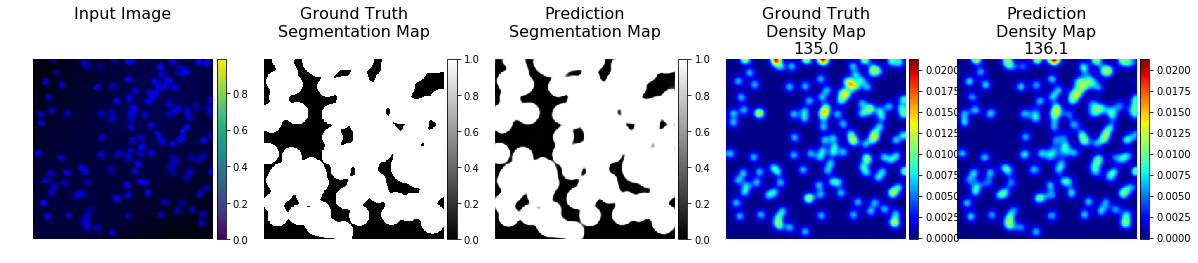

Epoch 1/1
 - 0s - loss: 0.0317 - activation_1_loss: 0.0358 - conv2d_12_loss: 0.0299
Epoch 1/1
 - 0s - loss: 0.0350 - activation_1_loss: 0.0356 - conv2d_12_loss: 0.0347
Epoch 1/1
 - 0s - loss: 0.0640 - activation_1_loss: 0.0442 - conv2d_12_loss: 0.0724
Epoch 1/1
 - 0s - loss: 0.1409 - activation_1_loss: 0.1342 - conv2d_12_loss: 0.1437
Epoch 1/1
 - 0s - loss: 0.0615 - activation_1_loss: 0.1352 - conv2d_12_loss: 0.0300
Epoch 1/1
 - 0s - loss: 0.0638 - activation_1_loss: 0.0766 - conv2d_12_loss: 0.0583
Epoch 1/1
 - 0s - loss: 0.0829 - activation_1_loss: 0.1397 - conv2d_12_loss: 0.0586
Epoch 1/1
 - 0s - loss: 0.0518 - activation_1_loss: 0.0779 - conv2d_12_loss: 0.0406
Epoch 1/1
 - 0s - loss: 0.0636 - activation_1_loss: 0.0603 - conv2d_12_loss: 0.0650
Epoch 1/1
 - 0s - loss: 0.0486 - activation_1_loss: 0.0813 - conv2d_12_loss: 0.0345
Epoch 1/1
 - 0s - loss: 0.0546 - activation_1_loss: 0.0374 - conv2d_12_loss: 0.0620
Epoch 1/1
 - 0s - loss: 0.0470 - activation_1_loss: 0.0408 - conv2d_12_loss:

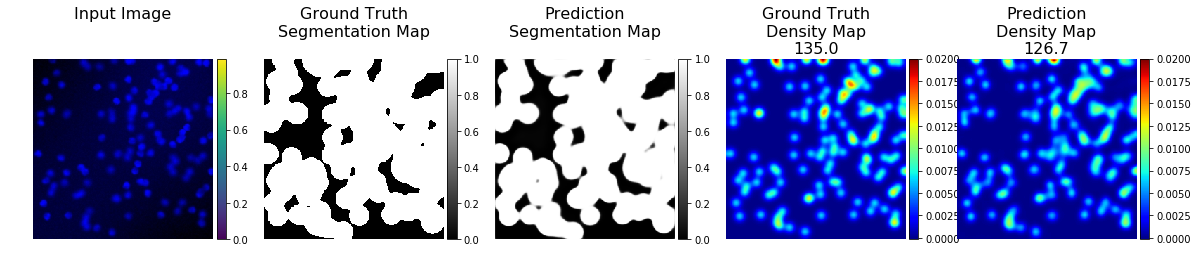

Epoch 1/1
 - 0s - loss: 0.0324 - activation_1_loss: 0.0443 - conv2d_12_loss: 0.0274
Epoch 1/1
 - 0s - loss: 0.0328 - activation_1_loss: 0.0310 - conv2d_12_loss: 0.0336
Epoch 1/1
 - 0s - loss: 0.0286 - activation_1_loss: 0.0324 - conv2d_12_loss: 0.0270
Epoch 1/1
 - 0s - loss: 0.0307 - activation_1_loss: 0.0314 - conv2d_12_loss: 0.0304
Epoch 1/1
 - 0s - loss: 0.0281 - activation_1_loss: 0.0294 - conv2d_12_loss: 0.0276
Epoch 1/1
 - 0s - loss: 0.0264 - activation_1_loss: 0.0274 - conv2d_12_loss: 0.0260
Epoch 1/1
 - 0s - loss: 0.0250 - activation_1_loss: 0.0276 - conv2d_12_loss: 0.0239
Epoch 1/1
 - 0s - loss: 0.0255 - activation_1_loss: 0.0310 - conv2d_12_loss: 0.0232
Epoch 1/1
 - 0s - loss: 0.0219 - activation_1_loss: 0.0248 - conv2d_12_loss: 0.0207
Epoch 1/1
 - 0s - loss: 0.0246 - activation_1_loss: 0.0305 - conv2d_12_loss: 0.0221
Epoch 1/1
 - 0s - loss: 0.0200 - activation_1_loss: 0.0249 - conv2d_12_loss: 0.0180
Epoch 1/1
 - 0s - loss: 0.0222 - activation_1_loss: 0.0257 - conv2d_12_loss:

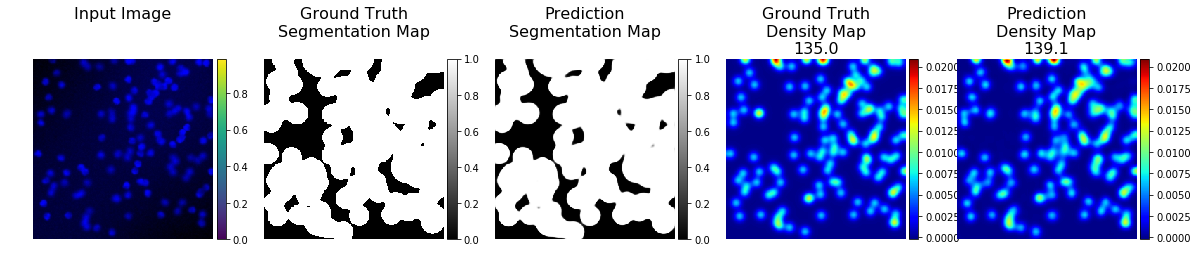

In [10]:
for i in range(100):
    model.fit(x, y, verbose=2)
    pred1, pred2 = model.predict(x)
    if (i + 1) % 20 == 0:
        print(f'Epoch {i+1:2d}:')
        plot_maps(img, gt_seg_map, pred1, gt_density_map, pred2)